In [145]:
function secODE(A,B,C,y0,yp0,Aₘ,ω,κ,t)
            quadsol = quadratic(A,B,C)[1]
            ODEreal = real(quadsol)
            ODEimag = abs(imag(quadsol))
            D1 = y0 - Aₘ*sin(κ)
            D2 = (yp0 - D1*ODEreal - Aₘ*ω*cos(κ))/ODEimag
             
            sol_general = D1*exp(ODEreal*t) * cos(ODEimag * t) + D2*exp(ODEreal*t) * sin(ODEimag * t)
            sol_particular = Aₘ*sin(ω*t + κ)
            return sol_general + sol_particular
        end

secODE (generic function with 1 method)

In [146]:
function quadratic(a, b, c)
          discr = b^2 - 4*a*c
          discr >= 0 ?   ( (-b + sqrt(discr))/(2a), (-b - sqrt(discr))/(2a) ) : ( (-b/a/2 + sqrt(c/a - b^2/a^2/4)im) , (-b/a/2 - sqrt(c/a - b^2/a^2/4)im) )
        end

quadratic (generic function with 1 method)

In [147]:
using Interact

In [148]:
using ComputationalHeatTransfer
using LaTeXStrings
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
using JLD2


cd(dirname(pwd()))
cd("src") 
includet("OneDOHP.jl")
using ..OneDOHP

In [149]:
using Plots
gr()  

Plots.GRBackend()

# Prescribed motion of liquid i liquid slug 1 (on the top left corner)

We introduce a prescribed motion for liquid i to be small perturbed oscillatory motion

$X_{p,1}(t) = X_{p,1}(0) + Amp \sin(2 \pi f t) $

$X_{p,2}(t) = X_{p,2}(0) + Amp \sin(2 \pi f t) $

### The liquid slug 2 will also a steady oscillation 

### conduction only

# Properies

### Earth property

In [150]:
g = 9.8

9.8

### Solid Physical parameters

In [151]:
ρₛ = 2700; # density
cₛ  = 8.97e02; # specific heat
kₛ  = 1.67e02; # heat conductivity
# d = 2e-3;
plate_d = 2e-3;  # plate thickness
params = HeatConductionParameters(ρₛ ,cₛ ,kₛ ,thickness=plate_d)

HeatConductionParameters(2700.0, 897.0, 167.0, 6.895412692514142e-5, 0.002)

### Fluid Physical parameters

In [152]:
fluid_type = "butane"
Tᵥ = 295.0

295.0

In [153]:
Cpₗ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",0.0,fluid_type)
ρₗ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",0.0,fluid_type)
μₗ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",0.0,fluid_type)
hₗ = CoolProp.PropsSI("H","T",Tᵥ,"Q",0.0,fluid_type)
kₗ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",0.0,fluid_type)
Prₗ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",0.0,fluid_type)

Cpᵥ = CoolProp.PropsSI("CPMASS","T",Tᵥ,"Q",1.0,fluid_type)
ρᵥ  = CoolProp.PropsSI("D","T",Tᵥ,"Q",1.0,fluid_type)
μᵥ  = CoolProp.PropsSI("V","T",Tᵥ,"Q",1.0,fluid_type);
hᵥ = CoolProp.PropsSI("H","T",Tᵥ,"Q",1.0,fluid_type)
kᵥ = CoolProp.PropsSI("CONDUCTIVITY","T",Tᵥ,"Q",1.0,fluid_type)
Prᵥ = CoolProp.PropsSI("PRANDTL","T",Tᵥ,"Q",1.0,fluid_type)

σ = CoolProp.PropsSI("I","T",Tᵥ,"Q",0.0,fluid_type)
P = CoolProp.PropsSI("P","T",Tᵥ,"Q",0.0,fluid_type)
R = CoolProp.PropsSI("GAS_CONSTANT","T",Tᵥ,"Q",1.0,fluid_type)
M = CoolProp.PropsSI("M","T",Tᵥ,"Q",1.0,fluid_type)
Rkg = R/M

αₗ = kₗ/ρₗ/Cpₗ
νₗ = μₗ/ρₗ
νᵥ = μᵥ/ρᵥ;
hₗᵥ = hᵥ-hₗ;

# Plate Conduction

### Geometry parameters

In [154]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

In [155]:
xlim = (-Lx/2,Lx/2) .*1.0
ylim = (-Ly/2,Ly/2) .*1.0
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.3)


(0.0005516330154011314, 0.001323919236962715)

### Set up the evaporator and condenser

In [156]:
inch = 2.54e-2;

In [157]:
power = 40 *0 #watts
total_heater_area = 2.0inch*2.0inch;

In [158]:
qe = power/total_heater_area
hc = 1500.0 * 0
Tc = Tᵥ

295.0

In [159]:
eb1 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((0.7inch,-0.0),0.0)
Tfe(eb1)

eb2 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((-0.7inch,-0.0),0.0)
Tfe(eb2)

cb1 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((-2.5inch,-0.0),0.0)
Tfc(cb1)

cb2 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((2.5inch,-0.0),0.0)
Tfc(cb2)

eparams1 = PrescribedHeatFluxRegion(qe,eb1);
eparams2 = PrescribedHeatFluxRegion(qe,eb2);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

In [160]:
ds = 1.5Δx
nturn = 16
width_ohp = 46.25*1e-3
length_ohp = 133.83*1e-3
gap = plate_d
pitch = width_ohp/(2*nturn+1)
x0, y0 = length_ohp/2, width_ohp/2

# x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,length_ohp,gap,ds,x0,y0,false,false,3pi/2)
one_loop_gap = 1e-2
x, y, xf, yf = construct_oneloop_curve(0,0,ds,length_ohp,one_loop_gap,pi/2)


ohp = BasicBody(x,y)

Basic pointwise-specified body with 362 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


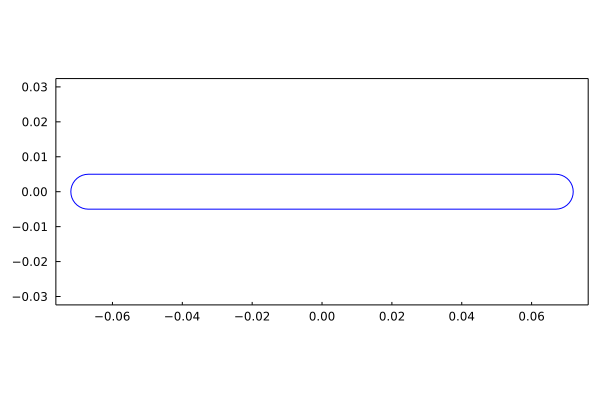

In [161]:
plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)

In [162]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)

LineSourceParams{BasicBody{362,RigidBodyTools.ClosedBody}}(Basic pointwise-specified body with 362 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
)

### Create the system

In [163]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom,qflux=[eparams1,eparams2],qmodel=[cparams1,cparams2])

Unbounded Heat conduction system on a grid of size 280 x 120 and 0 static immersed points


# OHP inner part

### Tube geometries

In [164]:
tube_d = 1e-3; # tube diameter
peri = 4*tube_d # Tube perimeter
Ac = tube_d*tube_d # tube cross-sectional area
L2D = length_ohp # the actual length of the bended pipe in the real world
L = (sys.qline[1].arccoord[1] + sys.qline[1].arccoord[end])  # total length of the pipe when streched to a 1D pipe (an approximate here)
angle = 0*pi/2 # inclination angle 
closedornot = true

true

In [165]:
tube = Tube(tube_d,peri,Ac,L,L2D,angle,g,closedornot);

### Prescribed X

In [166]:
Amp = 1e-3 * L2D
ω= 160.0

160.0

In [167]:
Pres_X(Xinit::Float64,t::Float64) = Xinit + Amp*sin(ω*t)

Pres_X (generic function with 1 method)

### Liquid

In [168]:
Nu = 4.36
Hₗ = kₗ/tube_d * Nu # Nusselt number 4.36

462.26761711088227

In [169]:
# X0,realratio = randomXp(L,numofslugs=60,chargeratio=0.45)
X0 = [(0.0,0.0+0.5L2D),(L/2,L/2+0.5L2D)]

dXdt0_l = zeros(length(X0))
dXdt0_r = zeros(length(X0)) 
dXdt0 = map(tuple,dXdt0_l,dXdt0_r)

# dXdt0[2] = (1.0,1.0)

2-element Array{Tuple{Float64,Float64},1}:
 (0.0, 0.0)
 (0.0, 0.0)

In [170]:
# construct liquids
N=numpts(ohp)
Xarrays,θarrays = constructXarrays(X0,N,Tᵥ,L);

In [171]:
liquids=Liquid(Hₗ,ρₗ,Cpₗ,αₗ,μₗ,X0,dXdt0,Xarrays,θarrays);

### Vapor

In [172]:
P = 0*zeros(length(X0)) .+ TtoP.([Tᵥ,Tᵥ]);
δ = 0*zeros(length(X0)) .+ 0.1*tube_d;
# δ = 0*zeros(length(X0)) .+ 2.78E-02;
vapors=Vapor(kₗ,P,δ);

In [173]:
P

2-element Array{Float64,1}:
 220337.82769062277
 220337.82769062277

### Wall

nucleate boiling sites

In [174]:
ΔTthres = 100.0; # superheat threshold

    nucleatenum = 256
    Xstations = sort(rand(nucleatenum).*L);
#     Xstations = LinRange(0.0,L-L/nucleatenum,nucleatenum)
#     boilingΔt = 0.05

In [175]:
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,Tᵥ);
θwallarray .= Tᵥ

wall = Wall(ΔTthres,Xstations,Xwallarray,θwallarray);

In [176]:
sys0_nomapping = PHPSystem_nomapping(tube,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [177]:
sys0 = PHPSystem(tube,liquids,vapors,wall,mapping);

### construct state vector U

In [178]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = PtoD(P) .* Lvaporplug .* Ac
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [179]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

# combine inner tube and plate together

In [180]:
tspan = (0.0, 1.0);
dt_record = tspan[2] /1000;

tstep=1e-5

N_iter = 1
# tstep_plate = tstep/N_iter
# dt_record = tstep

1

In [181]:
ΔT = 0.0 #[K]

0.0

In [182]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
# Tplate = temperature(integrator_plate);
temperature(integrator_plate) .= Tᵥ + ΔT;

In [183]:
p = sys0
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, dt=tstep, callback=cbst);

In [184]:
plate_hist = []
tube_hist  = []

currentsys = integrator_tube.p
currentsys = getcurrentsys(integrator_tube.u,currentsys);

currentsys.wall.θarray = temperature_linesource(integrator_plate)
currentsys = getcurrentsys(integrator_tube.u,currentsys)
integrator_tube.p = currentsys
qtmp = sys_to_heatflux(currentsys)
set_linesource_strength!(sys,qtmp);

In [185]:
push!(plate_hist,deepcopy(integrator_plate)); 
push!(tube_hist,deepcopy(integrator_tube));

In [186]:
currentsys.liquid.Xp[1][1]

0.0

In [187]:
integrator_tube.u

174-element Array{Float64,1}:
   0.0
   0.066915
   0.14966946308817156
   0.21658446308817156
   0.0
   0.0
   0.0
   0.0
   4.6499965085316096e-7
   4.6499965085316096e-7
   0.0001
   0.0001
  -1.0e10
   ⋮
 295.0
 295.0
 295.0
 295.0
 295.0
 295.0
 295.0
 295.0
 295.0
 295.0
 295.0
 295.0

In [188]:

@time for t in tspan[1]:tstep:tspan[2]
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t-tstep,integrator_plate.t), currentsys)
    integrator_tube = init(prob, RK4(), callback=cbst, dt=tstep);
    step!(integrator_tube,tstep,true);
    
    
      for j in 1:N_iter
        currentsys.wall.θarray = temperature_linesource(integrator_plate)
        
        
        mindex = Int64(1)
        integrator_tube.u[2*mindex-1:2*mindex] = [Pres_X(X0[mindex][1],t),Pres_X(X0[mindex][2],t)]
        
#         mindex = Int64(2)
#         integrator_tube.u[2*mindex-1:2*mindex] = [X0[mindex][1],X0[mindex][2]]
#         currentsys.liquid.Xp[mindex][2] = Pres_X(X0[mindex][2],t)
        
        currentsys = getcurrentsys(integrator_tube.u,currentsys)

#         qtmp = sys_to_heatflux(currentsys)
#         set_linesource_strength!(sys,qtmp)


#      ADI_timemarching!(temperature(integrator_plate),sys,tstep)
    end
    integrator_plate.t += tstep
    

    if (mod(integrator_plate.t,dt_record) < 1e-8) || (mod(-integrator_plate.t,dt_record) < 1e-8)
#         push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_tube.t)
    end
    
end

0.000990000000000002
0.0019900000000000044
0.002990000000000007
0.003990000000000006
0.004989999999999965
0.005989999999999924
0.0069899999999998835
0.007989999999999843
0.008989999999999802
0.009989999999999761
0.01098999999999972
0.01198999999999968
0.012989999999999639
0.013989999999999598
0.014989999999999557
0.01598999999999952
0.016989999999999478
0.017989999999999437
0.018989999999999396
0.019989999999999356
0.020989999999999315
0.021989999999999274
0.022989999999999233
0.023989999999999193
0.024989999999999152
0.02598999999999911
0.02698999999999907
0.02798999999999903
0.02898999999999899
0.029989999999998948
0.030989999999998907
0.03198999999999912
0.03298999999999943
0.033989999999999736
0.03499000000000004
0.03599000000000035
0.036990000000000654
0.03799000000000096
0.03899000000000127
0.03999000000000157
0.04099000000000188
0.041990000000002185
0.04299000000000249
0.0439900000000028
0.044990000000003104
0.04599000000000341
0.046990000000003716
0.04799000000000402
0.04899000

0.40999000000026925
0.41099000000027025
0.41199000000027125
0.41299000000027225
0.41399000000027325
0.41499000000027425
0.41599000000027525
0.41699000000027625
0.41799000000027725
0.41899000000027825
0.41999000000027925
0.42099000000028025
0.42199000000028125
0.42299000000028225
0.42399000000028325
0.42499000000028425
0.42599000000028525
0.42699000000028625
0.42799000000028725
0.42899000000028825
0.42999000000028925
0.43099000000029025
0.43199000000029125
0.43299000000029225
0.43399000000029325
0.43499000000029425
0.43599000000029525
0.43699000000029625
0.43799000000029725
0.43899000000029825
0.43999000000029925
0.44099000000030025
0.44199000000030125
0.44299000000030225
0.44399000000030325
0.44499000000030425
0.44599000000030525
0.44699000000030625
0.44799000000030725
0.44899000000030825
0.44999000000030925
0.45099000000031025
0.45199000000031125
0.45299000000031225
0.45399000000031325
0.45499000000031425
0.45599000000031525
0.45699000000031625
0.45799000000031725
0.45899000000031825


0.8379899999988211
0.8389899999988165
0.839989999998812
0.8409899999988074
0.8419899999988029
0.8429899999987983
0.8439899999987938
0.8449899999987892
0.8459899999987847
0.8469899999987801
0.8479899999987756
0.848989999998771
0.8499899999987665
0.8509899999987619
0.8519899999987574
0.8529899999987528
0.8539899999987483
0.8549899999987437
0.8559899999987391
0.8569899999987346
0.85798999999873
0.8589899999987255
0.8599899999987209
0.8609899999987164
0.8619899999987118
0.8629899999987073
0.8639899999987027
0.8649899999986982
0.8659899999986936
0.8669899999986891
0.8679899999986845
0.86898999999868
0.8699899999986754
0.8709899999986709
0.8719899999986663
0.8729899999986618
0.8739899999986572
0.8749899999986527
0.8759899999986481
0.8769899999986436
0.877989999998639
0.8789899999986345
0.8799899999986299
0.8809899999986254
0.8819899999986208
0.8829899999986163
0.8839899999986117
0.8849899999986072
0.8859899999986026
0.8869899999985981
0.8879899999985935
0.888989999998589
0.8899899999985844
0

In [189]:
sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

# plot the OHP

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
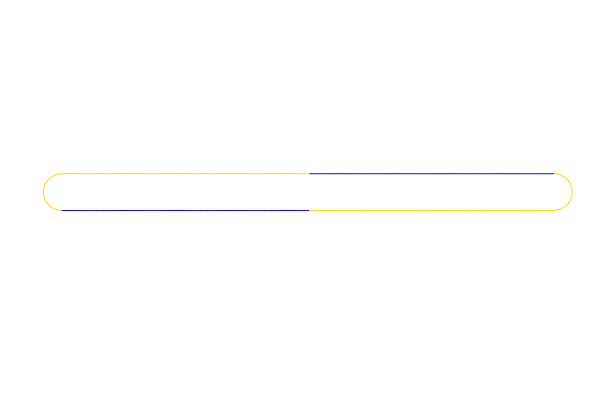

In [190]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing)
end

In [191]:
# @gif for ii=1:length(sysfinal)
#      plot(sysfinal[ii],plottype="T",ylim=(295.0-0.05,295.0+0.05))
# end

In [192]:
t_hist = []
for ii = 1:length(sysfinal)
    push!(t_hist,tube_hist[ii].t)
end
t_hist;

In [193]:
P_hist1 = []
P_hist2 = []
for ii = 1:length(sysfinal)
    push!(P_hist1,sysfinal[ii].vapor.P[1])
    push!(P_hist2,sysfinal[ii].vapor.P[2])
end
P_hist1
P_hist2;

In [194]:
(maximum(P_hist1-P_hist2)-minimum(P_hist1-P_hist2))/2 

470.8602375650371

In [195]:
(maximum(P_hist2)-minimum(P_hist2))/2 

235.38728835123766

In [196]:
(maximum(P_hist1)-minimum(P_hist1))/2

235.47294921379944

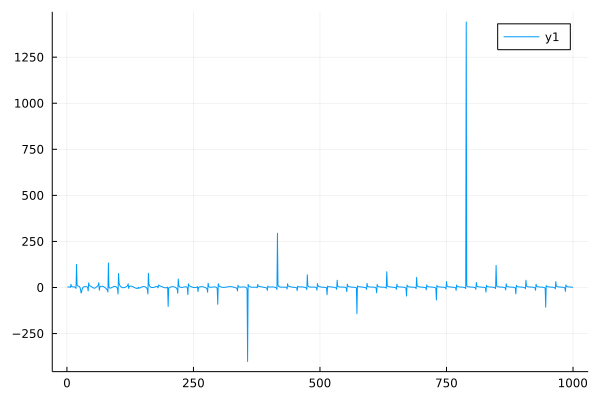

In [197]:
k = -(P_hist1-P_hist2)/2 *Ac ./ (Xp_hist1 .- Xp_hist1[1] - (Xp_hist2 .- Xp_hist2[1]))
plot(k[2:end])

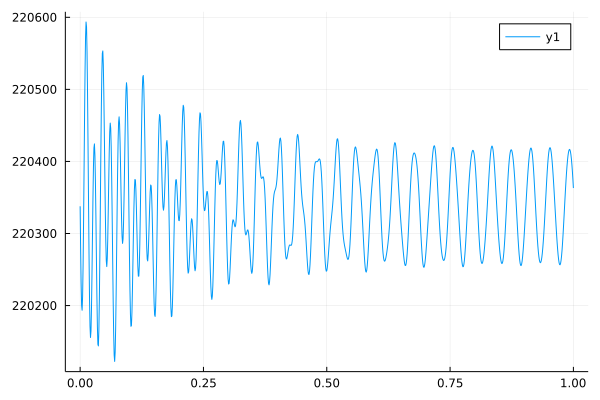

In [198]:
plot(t_hist,P_hist1)

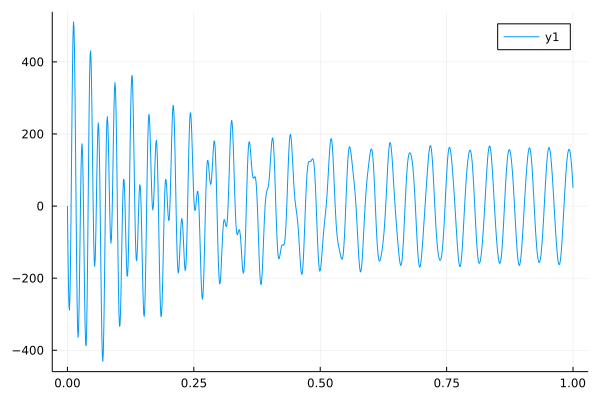

In [199]:
plot(t_hist,P_hist1-P_hist2)

In [200]:
Xp_hist1 = []
for ii = 1:length(sysfinal)
    push!(Xp_hist1,sysfinal[ii].liquid.Xp[1][2])
end
Xp_hist1;

In [201]:
Xp_hist2 = []
for ii = 1:length(sysfinal)
    push!(Xp_hist2,sysfinal[ii].liquid.Xp[2][2])
end
Xp_hist2;

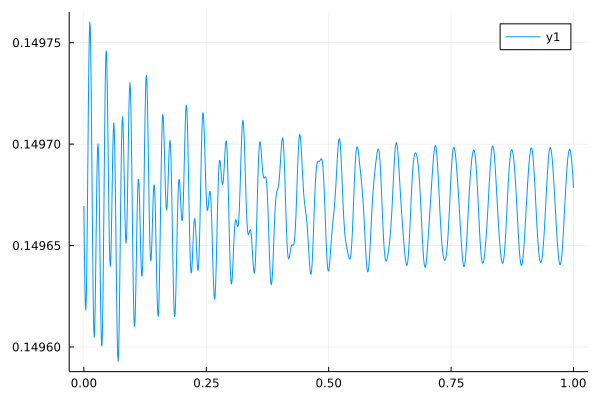

In [202]:
plot(t_hist,Xp_hist2 .- Xp_hist1)

In [203]:
ODEsol[1:100:end] ./ Amp

1001-element Array{Float64,1}:
 0.0
 0.004711757538570916
 0.033230956947970444
 0.10340824862368032
 0.22576430871363617
 0.4015110739428961
 0.6219704371194787
 0.8694737476664888
 1.1196108193375724
 1.3445029939500337
 1.5166288589464116
 1.6126540221604846
 1.6167184189515538
 ⋮
 1.1082221353500215
 1.169800380919379
 1.202110916463523
 1.2043882312865315
 1.176536616061389
 1.11913887121246
 1.0334607022562026
 0.9214478059354173
 0.7857114095756472
 0.6294975244345442
 0.45663553331379586
 0.2714629456077366

In [204]:
X2

1001-element Array{Float64,1}:
 -0.0036165511184148586
  0.0
  0.024685952950117506
  0.08687924369684484
  0.1954421791920989
  0.3504833604417237
  0.5435289629583859
  0.7589292299183007
  0.9762214277071749
  1.1730569288660806
  1.3282495092460547
  1.42451666507169
  1.450558806147443
  ⋮
  1.0403161353984172
  1.12148863770827
  1.1739405656338706
  1.1963319729504314
  1.1880907828635212
  1.1494274160104003
  1.0813294317049527
  0.9855363168050529
  0.8644950639148863
  0.7212976719248083
  0.5596021643693687
  0.38353914298379554

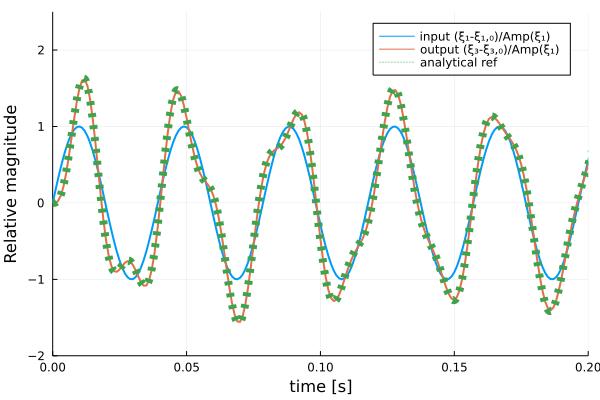

In [260]:
X1 = (Xp_hist1 .- Xp_hist1[1])/Amp
X2 = (Xp_hist2 .- Xp_hist2[2])/Amp

plot(t_hist,X1,label="input (ξ₁-ξ₁,₀)/Amp(ξ₁)",linewidth=2.0)
plot!(t_hist,X2,label="output (ξ₃-ξ₃,₀)/Amp(ξ₁)",linewidth=2.0)
# plot!(t,ODEsol ./ Amp,xlim=(0.0,0.1),ylim=(1.0,1.2))
plot!(t,ODEsol ./ Amp,label="analytical ref",style=:dot,linewidth=8.0,xlim=(0.0,0.2),ylim=(-2.0,2.5),ylabel ="Relative magnitude", xlabel ="time [s]" )
# savefig("oscillation_validation.pdf")

In [206]:
maximum(X2[Int64(floor(Int,length(X2)/2)):end])
# maximum(X2)

1.237838006654506

In [207]:
# 23.35077408193897 1e-4

### Compare with analytical result at the beginning

In [208]:
Lliquidslug = XptoLliquidslug(sys0.liquid.Xp,sys0.tube.L)

2-element Array{Float64,1}:
 0.066915
 0.066915

In [209]:
Lvaporslug = XptoLvaporplug(sys0.liquid.Xp,sys0.tube.L,closedornot)

2-element Array{Float64,1}:
 0.08275446308817155
 0.08275446308817155

In [210]:
Hᵥ=kₗ/δ[1]

1060.2468282359685

In [211]:
ΔT * (Hᵥ * peri * Lvaporslug[1] + Hₗ * peri * Lliquidslug[1])

0.0

### Analytical solution for phase angle and magnitude

In [212]:
Ls = X0[1][2]-X0[1][1]

0.066915

In [213]:
L2D

0.13383

In [214]:
M[1]

4.6499965085316096e-7

In [215]:
dPdT = CoolProp.PropsSI("d(P)/d(T)|sigma","T",Tᵥ,"Q",1.0,fluid_type)
dρdT = CoolProp.PropsSI("d(D)/d(T)|sigma","T",Tᵥ,"Q",1.0,fluid_type)
dPdρ = dPdT/dρdT

41438.06409879956

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
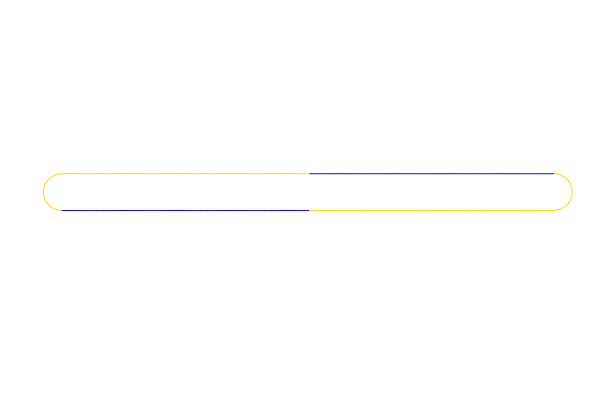

In [261]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing)
end

In [216]:
 @manipulate for relative_Lₗ = 0.1:0.05:1.0,relative_Lᵥ = 0.1:0.05:1.0
    Ls = L2D*relative_Lₗ
    A = Ac .* Ls .* ρₗ
    B = 8*μₗ/tube_d * peri .* Ls
    
#     relative_Lᵥ = 0.5
    Lᵥ = L2D * relative_Lᵥ
    Mᵥ = ρᵥ * Ac * Lᵥ
    k = -Ac^2/Mᵥ * dPdρ * (-ρᵥ^2)
#     k = -Ac^2/M[1] * dPdρ * (-ρᵥ^2)
    
    
    Dtemp = sqrt((2k - A*ω^2)^2 + (B*ω)^2 )
    ωh = 1.0:1.0:1000.0
    Dh = sqrt.((2k .- A .* ωh.^2).^2 + (B .* ωh).^2 )
    mh = 2*k*Amp ./ (Dh)/Amp;
    
    plot((ωh ./ 2 ./ pi),mh, xlabel="vibration frequency [Hz]", ylabel ="Relative output magnitude", label="A/A₀")
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["relative_Lₗ"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 19,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
10, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\liyux\\.julia\\packages\\Knockout\\3gjS1\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\liyux\\.julia\\packages\\Knockout\\3gjS1\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\liyux\\.julia\\packages\\InteractBase\\o1I6G\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\liyux\\.julia\\packages\\InteractBase\\o1I6G\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\liyux\\.julia\\packages\\Interact\\pVyN2\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000001497b6b0, Task (runnable) @0x000000001497b6b0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.1\",\"0.15\",\"0.2\",\"0.25\",\"0.3\",\"0.35\",\"0.4\",\"0.45\",\"0.5\",\"0.55\",\"0.6\",\"0.65\",\"0.7\",\"0.75\",\"0.8\",\"0.85\",\"0.9\",\"0.95\",\"1.0\"],\"changes\":WebIO.

In [217]:
Ls

0.066915

In [218]:
Tᵥ

295.0

In [219]:
A = Ac .* Ls .* ρₗ

3.8574675711589845e-5

In [220]:
A = Ac .* Ls .* ρₗ
B = 8 .* μₗ./ tube_d .* peri .* Ls

0.00034951571322190515

In [221]:
k = -Ac^2/M[1] * dPdρ * (-ρᵥ^2)

2.8136298590051902

In [222]:
Dtemp = sqrt((2k - A*ω^2)^2 + (B*ω)^2 )
κ = -asin(Amp*(B*ω) /Dtemp)

-1.6129252002948663e-6

In [223]:
Aₘ = 2*k*Amp/(Dtemp)

0.00016230223464260742

In [224]:
# Aₘ/Amp

In [225]:
ωh = 1.0:1.0:1000.0

1.0:1.0:1000.0

In [226]:
Dh = sqrt.((2k .- A .* ωh.^2).^2 + (B .* ωh).^2 )

1000-element Array{Float64,1}:
  5.627221154189159
  5.627105462726387
  5.626912643624745
  5.626642696888696
  5.626295622524492
  5.625871420540174
  5.625370090945573
  5.624791633752312
  5.624136048973807
  5.623403336625276
  5.622593496723731
  5.621706529287993
  5.620742434338688
  ⋮
 32.10530160137008
 32.18164022633644
 32.258056003109274
 32.33454893167589
 32.41111901202365
 32.487766244140005
 32.564490628012514
 32.64129216362878
 32.718170850976534
 32.79512669004354
 32.87215968081769
 32.949269823286905

In [227]:
mh = 2*k*Amp ./ (Dh)/Amp;

In [228]:
ωh

1.0:1.0:1000.0

In [229]:
Dh2 = sqrt.((2k .- A .* ωh.^2).^2 + (B .* ωh).^2 )
mh2 = 2*k*Amp ./ (Dh2)/Amp

1000-element Array{Float64,1}:
 1.0000068530843493
 1.000027412900827
 1.0000616811398393
 1.0001096606191158
 1.0001713552842884
 1.0002467702097024
 1.0003359115994606
 1.000438786788698
 1.0005554042450917
 1.000685773570604
 1.0008299055034602
 1.0009878119203586
 1.0011595058389222
 ⋮
 0.17527509281427336
 0.1748593197373827
 0.17444509729501315
 0.1740324174585206
 0.17362127225298266
 0.17321165375675526
 0.17280355410103415
 0.1723969654694206
 0.17199188009749097
 0.17158829027237124
 0.17118618833231475
 0.17078556666628505

In [230]:
C=2k

5.6272597180103805

In [231]:
B^2 - 4*A*(2k)
# < 0

-0.0008681567138347828

In [232]:
ODEimag

381.9150604485947

In [233]:
quadsol = quadratic(A,B,C)[1]
ODEreal = real(quadsol)
ODEimag = abs(imag(quadsol))

381.9150604485947

In [234]:
ODEreal

-4.530377855087092

In [235]:
ω

160.0

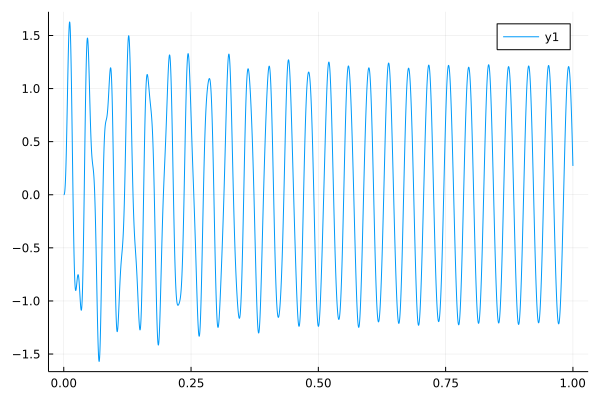

In [236]:
y0 = 0;
yp0 = 0;
t = 0.0:1e-5:1.0
ODEsol = secODE.(A,B,C,y0,yp0,Aₘ,ω,κ,t)
plot(t,ODEsol ./ Amp)

In [237]:
sqrt(C/A)

381.9419297759328

In [238]:
ωᵣ = sqrt(C/A-B^2/A^2/4)
fᵣ = ωᵣ ./ 2 ./ pi

60.78366971163386

In [239]:
D1 = y0 - Aₘ*sin(κ)
D2 = (yp0 - D1*ODEreal - Aₘ*ω*cos(κ))/ODEimag

-6.799510950501053e-5